<Figure size 1200x500 with 4 Axes>

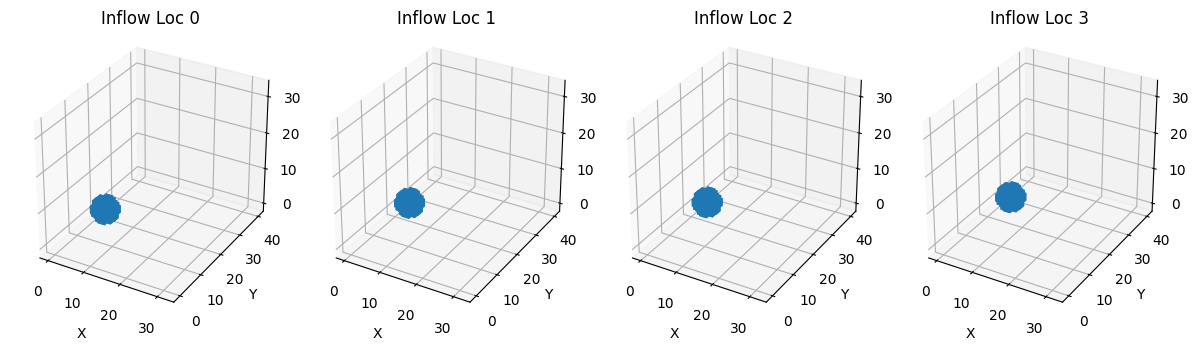

In [67]:
from phi.torch.flow import *

bound = Box(x=(0, 32), y=(0, 40), z=(0, 32))
res = spatial(x=32, y=40, z=32)
inflow_loc = tensor([(12, 4, 12), (13, 6, 13), (14, 5, 14), (16, 5, 16)], batch('inflow_loc'), channel(vector="x,y,z"))

SMOKE_INIT = CenteredGrid(values=math.zeros(batch(inflow_loc=4)), boundary=extrapolation.ZERO_GRADIENT, bounds=bound,
                          resolution=res)
VELOCITY_INIT = StaggeredGrid(values=math.zeros(batch(inflow_loc=4)), boundary=extrapolation.ZERO,
                              bounds=bound, resolution=res)
INFLOW = (1. / 3.) * CenteredGrid(values=Sphere(center=inflow_loc, radius=3), boundary=extrapolation.ZERO_GRADIENT,
                                  bounds=bound, resolution=res)


@jit_compile
def step(in_smoke: CenteredGrid, in_velocity: StaggeredGrid, in_inflow: CenteredGrid, in_dt: float = 1,
         buoyancy_factor: float = 1):
    if SMOKE_INIT.shape.spatial.shape.size == 2:
        _buoyancy = (in_smoke * (0, buoyancy_factor)).at(in_velocity)
    elif SMOKE_INIT.shape.spatial.shape.size == 3:
        _buoyancy = (in_smoke * (0, buoyancy_factor, 0)).at(in_velocity)
    else:
        raise ValueError('Invalid spatial dimension')
    in_smoke = advect.mac_cormack(field=in_smoke, velocity=in_velocity, dt=in_dt) + in_inflow
    in_velocity = advect.semi_lagrangian(field=in_velocity, velocity=in_velocity, dt=in_dt) + _buoyancy
    in_velocity, _pressure = fluid.make_incompressible(velocity=in_velocity)
    return in_smoke, in_velocity


def simulate(in_smoke: CenteredGrid, in_velocity: StaggeredGrid):
    in_smoke, in_velocity = step(in_smoke=in_smoke, in_velocity=in_velocity, in_inflow=INFLOW, in_dt=1)
    _loss = field.l2_loss(in_smoke - field.stop_gradient(in_smoke.inflow_loc[-1]))
    return _loss, in_smoke, in_velocity


f_sim_grad = field.functional_gradient(f=simulate, wrt='in_velocity', get_output=True)
(LOSS, SMOKE, VELOCITY), dVELOCITY = f_sim_grad(in_smoke=SMOKE_INIT, in_velocity=VELOCITY_INIT)

(LOSS, SMOKE, VELOCITY), dVELOCITY = f_sim_grad(in_smoke=SMOKE, in_velocity=VELOCITY)
